# KNN with serveral features
## merge datasets

In [82]:
# imports
from sklearn.neighbors import KNeighborsClassifier
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", "../functions.py")
functions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(functions)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [87]:
# define dataset as merge of all available datasets PCA, FT, Polynominal & default 
np.set_printoptions(precision=1)
df_default = pd.read_csv("../data/credit_train_processed.csv", index_col=0)
df_FT = pd.read_csv("../data/credit_train_processed__FTs.csv", index_col=0)
df_poly = pd.read_csv("../data/credit_train_processed__polynomial.csv", index_col=0)

target = df_default["Loan Status"]

df_default = df_default.drop(df_default[["Loan Status", "Credit Score"]], axis=1)
df_poly = df_poly.drop(df_poly[["Loan Status", "Credit Score"]], axis=1)
df_FT = df_FT.drop(df_FT[["Loan Status"]], axis=1)


In [88]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA

# Standardizing the features
df_PCA = StandardScaler().fit_transform(df_default)
pca = PCA(n_components = len(df_default.columns)-1)
    
X_pca = pca.fit_transform(df_PCA)
    
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)
sum = 0
counter = 0
for var in ex_variance_ratio:
    counter += 1
    sum += var
    if sum > 0.90:
        break
pca = PCA(n_components = counter)
    
df_PCA = pd.DataFrame(pca.fit_transform(df_default))

[9.0e-02 5.7e-02 5.4e-02 5.4e-02 5.0e-02 4.6e-02 3.4e-02 3.2e-02 3.0e-02
 3.0e-02 3.0e-02 2.9e-02 2.9e-02 2.9e-02 2.9e-02 2.9e-02 2.9e-02 2.9e-02
 2.9e-02 2.9e-02 2.8e-02 2.8e-02 2.8e-02 2.7e-02 2.6e-02 2.5e-02 2.3e-02
 1.9e-02 1.3e-02 1.1e-02 3.3e-03 2.7e-03 1.8e-32 2.1e-33]


In [90]:
select = SelectKBest(f_classif, k=3)
selected_features_pca = select.fit(df_PCA, target.values)
indices_selected_pca = selected_features_pca.get_support(indices=True)
colnames_selected_pca = [df_PCA.columns[i] for i in indices_selected_pca]

df_PCA = df_PCA[colnames_selected_pca]

select = SelectKBest(f_classif, k=3)
selected_features_ft = select.fit(df_FT, target.values)
indices_selected_ft = selected_features_ft.get_support(indices=True)
colnames_selected_ft = [df_FT.columns[i] for i in indices_selected_ft]

df_FT = df_FT[colnames_selected_ft]

select = SelectKBest(f_classif, k=3)
selected_features_poly = select.fit(df_poly, target.values)
indices_selected_poly = selected_features_poly.get_support(indices=True)
colnames_selected_poly = [df_poly.columns[i] for i in indices_selected_poly]

df_poly = df_poly[colnames_selected_poly]

select = SelectKBest(f_classif, k=3)
selected_features_default = select.fit(df_default, target.values)
indices_selected_default = selected_features_default.get_support(indices=True)
colnames_selected_default = [df_default.columns[i] for i in indices_selected_default]

df_default = df_default[colnames_selected_default]


df = df_default.reset_index(drop=True).merge(target.reset_index(drop=True), left_index=True, right_index=True)
df = df_poly.reset_index(drop=True).merge(df.reset_index(drop=True), left_index=True, right_index=True)
df = df_FT.reset_index(drop=True).merge(df.reset_index(drop=True), left_index=True, right_index=True)
df_with_pca = df_PCA.reset_index(drop=True).merge(df.reset_index(drop=True), left_index=True, right_index=True)

df_with_pca.head(10)

,0,2,13,Current Loan Amount + Term,1 / Current Loan Amount,Credit Score + Current Loan Amount,Current Loan Amount_x,Credit Ration per Year_x,Current Loan Amount^2,Current Loan Amount_y,Term,Credit Ration per Year_y,Loan Status
0,8.622449e+07,7.306387e+05,-0.243580,3.170315,0.395103,3.500711,2.530987,0.981006,6.405894,99999999.0,1.0,44.805035,0.0
1,-1.355825e+07,-2.868349e+05,-0.447374,0.241348,-2.512688,0.185342,-0.397980,-0.347665,0.158388,217646.0,1.0,0.183793,0.0
2,-1.322659e+07,1.118057e+06,-0.342832,0.251067,-2.575586,-1.631566,-0.388261,-0.346753,0.150747,548746.0,1.0,0.214428,0.0
3,8.622391e+07,-7.853911e+05,-0.157547,3.170315,0.395103,3.044054,2.530987,3.813597,6.405894,99999999.0,1.0,139.932943,0.0
4,8.622393e+07,-7.323161e+05,-0.243550,3.170315,0.395103,3.465583,2.530987,3.483131,6.405894,99999999.0,1.0,128.834766,0.0
5,-1.354197e+07,-7.859454e+05,-0.247020,0.241832,-2.515745,0.080443,-0.397497,-0.343082,0.158003,234124.0,1.0,0.337727,0.0
6,-1.310952e+07,4.177273e+05,0.415508,-1.948954,-2.598662,-0.047383,-0.384813,-0.342250,0.148081,666204.0,0.0,0.365651,0.0
7,-1.345880e+07,-3.438790e+05,0.568489,-1.959202,-2.531257,-1.322218,-0.395061,-0.344806,0.156073,317108.0,0.0,0.279816,1.0
8,-1.331029e+07,2.445135e+05,1.006052,-1.954848,-2.559460,-1.282738,-0.390707,-0.345093,0.152652,465410.0,0.0,0.270170,0.0
9,8.622433e+07,2.467649e+05,-0.361226,3.170315,0.395103,3.676348,2.530987,1.348630,6.405894,99999999.0,1.0,57.151086,0.0


## Run with ALL datasets merged to one

In [91]:
y = df['Loan Status']
X = df.drop(columns='Loan Status')

standard_scaler = StandardScaler()
X = pd.DataFrame(standard_scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

In [92]:
# param values
neighbors = range(1, 32, 2)
weight = ["uniform", "distance"]
pp = [1, 2]
algo = ["auto"]
metric = ["minkowski", "manhattan"]
# creating  grid instance
grid_params_nn = dict(n_neighbors=neighbors, weights=weight, p=pp, algorithm=algo, metric=metric)

In [93]:
# creating KNN instance
knn = KNeighborsClassifier()
knnCV = GridSearchCV(knn, grid_params_nn, cv=10, scoring='f1', verbose=10, n_jobs=-1)

knnCV.fit(X_train, y_train.values.ravel())

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'metric': ['minkowski', 'manhattan'], 'algorithm': ['auto'], 'p': [1, 2], 'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 32, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

In [94]:
# print results

best_score = knnCV.best_score_

best_params = knnCV.best_params_

print("Best score without PCA: {0}".format(best_score))
print("Best params without PCA: {0}".format(best_params))

f = open("../results/files/knn_tuning_results_temp.txt", "w+")

f.write("Best score = {0} \n".format(best_score))
f.write("Best params = {0} \n".format(best_params))

f.close()

Best score without PCA: 0.3069460062327976
Best params without PCA: {'p': 1, 'algorithm': 'auto', 'metric': 'minkowski', 'weights': 'uniform', 'n_neighbors': 1}


In [95]:
# create KNN instance
knn = knnCV.best_estimator_
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=1,
           weights='uniform')

In [96]:
y_pred = knn.predict(X_test)

In [97]:
# calculate F1 score
f1 = f1_score(y_test, y_pred)
"F1 score without PCA is = {0}".format(f1)

'F1 score without PCA is = 0.31429187324854496'

In [98]:
y = df_with_pca['Loan Status']
X = df_with_pca.drop(columns='Loan Status')

standard_scaler = StandardScaler()
X = pd.DataFrame(standard_scaler.fit_transform(X), columns=X.columns)
y = pd.DataFrame(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10, stratify=y)

In [99]:
# creating KNN instance
knn = KNeighborsClassifier()
knnCV = GridSearchCV(knn, grid_params_nn, cv=10, scoring='f1', verbose=10, n_jobs=-1)

knnCV.fit(X_train, y_train.values.ravel())

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'metric': ['minkowski', 'manhattan'], 'algorithm': ['auto'], 'p': [1, 2], 'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 32, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=10)

In [100]:
# print results

best_score = knnCV.best_score_

best_params = knnCV.best_params_

print("Best score with PCA: {0}".format(best_score))
print("Best params with PCA: {0}".format(best_params))

f = open("../results/files/knn_tuning_results_temp.txt", "a")

f.write("Best score with PCA = {0} \n".format(best_score))
f.write("Best params with PCA = {0} \n".format(best_params))

f.close()

Best score with PCA: 0.30992761721297013
Best params with PCA: {'p': 2, 'algorithm': 'auto', 'metric': 'minkowski', 'weights': 'uniform', 'n_neighbors': 1}


In [101]:
# create KNN instance
knn = knnCV.best_estimator_
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [102]:
y_pred_pca = knn.predict(X_test)

In [103]:
# calculate F1 score
f1_pca = f1_score(y_test, y_pred_pca)
"F1 score with PCA is = {0}".format(f1_pca)

'F1 score with PCA is = 0.3158124318429662'

Confusion matrix, without normalization


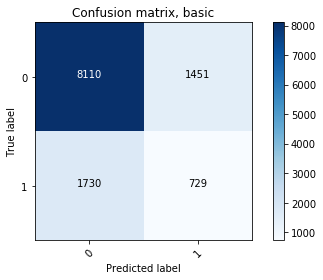

Confusion matrix, without normalization


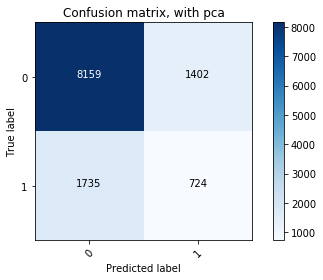

In [104]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
cm_final = confusion_matrix(y_test, y_pred)
cm_final_pca = confusion_matrix(y_test, y_pred_pca)

np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm_final, classes=['0','1'],
                      title='Confusion matrix, basic')
plt.show()
plt.figure()
plot_confusion_matrix(cm_final_pca, classes=['0','1'],
                      title='Confusion matrix, with pca')
plt.show()